# Keras

ニューラルネットワークの学習，実行を単純化する高水準深層学習API，ライブラリである．
Kerasは，ユーザが使いやすいように設計されたAPI．TensorFlowやTheanoにはこのAPIの独自実装が含まれているため，TensorFlow，Theano上で動く．

Kerasで出来ること
1. 文章の自動生成
2. 画像認識
3. botの作成

メリット
- 初学者が，比較的短いソースコードで実装できる．
- 可読性が高い．
- エラー時にフィードバックが明確でわかりやすい．

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import pandas as pd


In [ ]:
df = pd.read_csv('/content/boston.csv')
X = df.drop("house prices", axis=1)
y = df['house prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=53)

In [ ]:
''' features = [
            'INDUS',
            'RM',
            'TAX',
            'PTRATIO',
            'LSTAT'
]
X_train = X_train[features]
X_test = X_test[features] '''

" features = [\n            'INDUS',\n            'RM',\n            'TAX',\n            'PTRATIO',\n            'LSTAT'\n]\nX_train = X_train[features]\nX_test = X_test[features] "

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

## 回帰タスク

今回は，ボストンの住宅価格予測のデータを使用する．RNNやLSTMによる時系列数値データ予測ではない．

- SequentialモデルとFunctional API 

 ニューラルネットワークの構造は複雑であり，定義することが困難である．よって，構造(モデル)を簡略化することが可能．それが可能なモデルの一つがSequentialモデルである．
 Functional APIは，複数の出力を持ったモデルや有向非巡回グラフ，共有レイヤーを持ったモデルといった，Sequential モデルではできないような複雑なモデルが定義できる．

 今回は，Sequential モデルを使用する．

- レイヤーの追加

 .add() でレイヤーを追加できる．

- Dense
 
 レイヤーの種類で全結合を意味する．個々のノードが次のレイヤーのノード全てに繋がる．以下は，Denseの引数．

  - units(出力次元数)
   
   次のレイヤーのノードに入力される次元数(エッジの数)．units = 5 の場合，次のレイヤーの各ノードに対して，5つのデータが出力される．

  - activation(活性化関数)
   
   そのレイヤーの出力刺激量を計算する関数を指定する．

  - input_shape

   モデルはどのような入力のshapeを想定しているのかを知る必要がある．そのため，Sequentialモデルの最初のレイヤーにのみ入力のshapeの情報を与える必要がある．この引数にはshapeを示すタプルを与える．このタプルの要素は整数か Noneを取る．Noneは任意の正の整数を期待することを意味する．
  
  - input_dim

   2次元の層では input_dim引数を指定することで入力のshapeを指定できる．同様に，3次元のレイヤーでは input_dim引数と input_length引数を指定することで入力のshapeを指定できる．

- compile
  
  初期化したモデルで学習する際の，損失関数や最適化の方法を設定する．

- summary

  モデルに対しsummary()を呼び出すことで，モデルのすべての層の名前とタイプ，出力の形(Noneはバッチサイズがいくつでも良いという意味)，パラメータ数が表示され，パラメータ数と調整可能なパラメータ，調整不可能なパラメータの無い数が表示される．

- get_seights, set_weights

  これらのメソッドによって，層のすべてのパラメータを読み書きできる．

### 回帰における層について

| ハイパラメータ  | 一般的な値  |
|---|---|
| 入力ニューロン数  | 入力特徴量あたり1個  |
| 中間層(隠れ層)の数  | 一般的には1∼5  |
| 中間層毎のニューロン数  | 一般的には1∼100  |
| 出力ニューロン数  | 予測次元あたり1個  |
| 中間層の活性化関数  | ReLU  |
| 出力層の活性化関数  | なし，またはReLU/ソフトプラス(出力を正にする場合)<br> ロジスティック/双曲線正接(出力範囲が決まっている場合)  |
| 損失関数  | 平均二乗誤差か平均絶対誤差  |

今回は，畳み込み層などは特に設けず，全結合層のみで構成する．また，今回は最終的に住宅価格を出力するため，最後の全結合層のニューロンは1つにする．

In [ ]:
nn1 = 64
nn2 = 32
nn3 = 128

model = Sequential()
model.add(Dense(nn1, activation='relu', input_dim=(X_train.shape[1])))
model.add(BatchNormalization()) # バッチ正規化．各層の入力の最適なスケールと平均をモデルに学習させる．
model.add(Dense(nn1, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dense(nn3, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.2)) # 過学習予防．全結合の層とのつながりを25%無効化
model.add(Dense(nn2, activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
    )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

- バッチサイズ

損失関数を最小化して最適なパラメータチューニングを行うためのに勾配降下法が使われる．多くの場合，ミニバッチ勾配降下法と確率的勾配降下法の間をとった手法が使われ，データセットを複数のサブセットに分ける必要がある(学習データとテストデータに分けることとは異なる)．

複数に分けたサブセットに含まれるデータ数をバッチサイズという．バッチサイズは機械学習の分野の慣習1として2のn乗の値が使われることが多く，32, 64, 128, 256, 512, 1024, 2048辺りがよく使われる．

- イテレーション数

イテレーション数とは，データセットに含まれるデータが少なくとも1回は学習に用いられるために必要な学習回数であり，バッチサイズが決まれば，必然的に決定される．

- エポック数

1. データセットをバッチサイズに従ってN個のサブセットに分ける．
2. 各サブセットを学習に回す．つまり，N回学習を繰り返す．

エポック数とは，1と2のプロセスを繰り返し，実行する回数を意味する．

In [ ]:
train_history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=150,
    verbose=-1,
    validation_data=(X_val, y_val) # validation_split=0.1 のようにすると，事前に検証データを用意しなくても良い．(この場合は学習データの10%が使用される)
    )

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

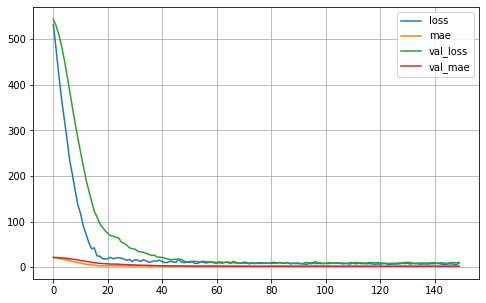

In [ ]:
pd.DataFrame(train_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

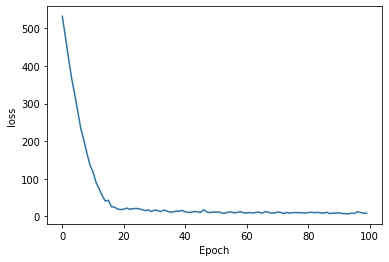

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(train_history.history['loss'][:100])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
# plt.savefig('nn-regression-train-2.png', dpi=300, facecolor='white')
plt.show()

テストデータによる評価は，evaluate()メソッドでも可能

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 15.5737 - mae: 2.8671


[15.573714256286621, 2.8670971393585205]

In [ ]:
y_pred = model.predict(X_test)
#print(y_pred)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
r2 = r2_score(y_test, y_pred)
print(r2)

0.8290314151885096


In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

3.9463547349138124


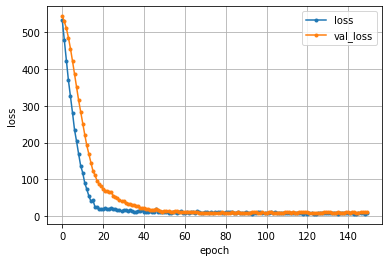

In [ ]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

正解値と予測値の散布図

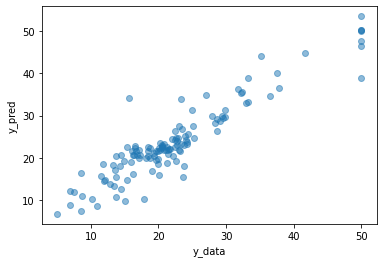

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(y_test, y_pred, alpha=0.5)
ax.set_xlabel('y_data')
ax.set_ylabel('y_pred')
# plt.savefig('nn-regression-predict.png', dpi=300, facecolor='white')
plt.show()

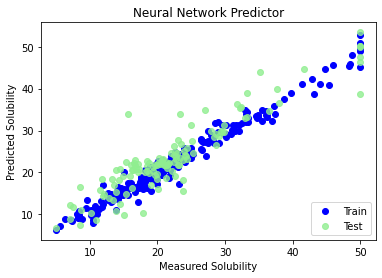

In [ ]:
plt.figure()
plt.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
plt.title('Neural Network Predictor')
plt.xlabel('Measured Solubility')
plt.ylabel('Predicted Solubility')
plt.scatter(y_test, model.predict(X_test), c = 'lightgreen', label = 'Test', alpha = 0.8)
plt.legend(loc = 4)
plt.show()

## モデルの保存と復元

KerasはHDF5形式を用いてモデルのアーキテクチャ(すべてのハイパラメータを含む)とすべての層のモデルパラメータの値，オプティマイザを保存する．

In [ ]:
model.save('keras_reg.h5')

#model = keras.models.load_model('keras_reg.h5')

## Hyperas

In [1]:
!pip install hyperas

### チューナーの設定

ハイパーパラメータチューニングを行うためには，最適化したいパラメータを{{}}で囲み，アルゴリズムを実行する分布を選択する．

choiceメソッドを使うと，全結合層のノードの数を2行目では，256個と512個を試している．3行目では，16個と32個，64個を試している．

In [ ]:
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [ ]:
# チューナーを定義
model = Sequential()
model.add(Dense({{choice([256, 512])}}, input_shape=(X_train.shape[1])))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout({{uniform(0.15, 0.2, 0.25)}}))
model.add(Dense({{choice([256, 512, 1024])}}))
model.add(Activation({{choice(['relu','softplus'])}}))
model.add(Dense(1))

model.compile(optimizer={{choice(['adam', 'sgd'])}},
              loss='mse',
              metrics=['mae'])

TypeError: ignored

In [ ]:
result = model.fit(X_train, y_train,
              batch_size={{choice([32, 64])}},
              epochs=2,
              verbose=1,
              validation_split=0.1)

In [ ]:
best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials())